In [ ]:
#!/usr/bin/python3
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
num_GPU = 1
mem_growth = True

import tensorflow as tf
# tf.get_logger().setLevel('INFO')
print('Tensorflow version: ', tf.__version__)

gpus = tf.config.experimental.list_physical_devices("GPU")
print('Number of GPUs available :', len(gpus))

tf.config.experimental.set_visible_devices(gpus[num_GPU], 'GPU')
tf.config.experimental.set_memory_growth(gpus[num_GPU], mem_growth)
print('Used GPU: {}. Memory growth: {}'.format(num_GPU, mem_growth))

import numpy as np
import pickle
from tqdm import tqdm
from tensorflow.keras import Model
import os
import shutil

# from settings import SETTINGS
from AWGN_settings_1TxU import SETTINGS
from libphy.coding.Parity_Bit import Parity_Bit
from libphy.rg.Interleaver import Interleaver
from libphy.modulation.GS import GS
from libphy.modulation.QAM import QAM
from libphy.rxnn.RXNN import RXNN
from libphy.coding.BP_Decoder_SumProd import BP_Decoder
from libch.channel.channel_preproc import ChannelPreProcess
from libch.channel.dataset_gen_parser import DatasetGenerator
from libch.channel.multipath_channel import MultiPathChannel
from libphy.waveform.OFDM import OFDM

# tf.config.run_functions_eagerly(True)

In [1]:
from libphy.modulation.GS import GS

In [3]:
GS

libphy.modulation.GS.GS

In [9]:
now_user = 0

In [3]:
class SysGS(Model):
        
    # velocity in m/s
    def __init__(self, training, fine_tuning = False, **kwargs):
        super(SysGS, self).__init__(**kwargs)
        
        # Training/Evaluating
        self.training = tf.constant(training, tf.bool)
        # Fine tuning or not. At fine tuning GS nontrainable; otherwise, trainable
        self.fine_tuning = tf.constant(fine_tuning, tf.bool)

        H = SETTINGS['PCM'][SETTINGS['code_rate']]
        self.bit_info_per_codeword = H.shape[1] - H.shape[0]
        self.bit_par_per_codeword = H.shape[0]
        self.codeword_length = H.shape[1]
        
        assert self.codeword_length % SETTINGS['bit_per_cu'] == 0
        self.sym_per_codeword = self.codeword_length // SETTINGS['bit_per_cu']
        
        if training:
            self.optimizer = tf.optimizers.Adam(SETTINGS['learning_rate'])
                
    def build(self, input_shape):
        
        # Trainable modulation
        self.gs = GS(SETTINGS['bit_per_cu'])
        
         # At fine tuning phase, set to non-trainable
        if self.fine_tuning:
            self.gs.trainable = False
            print('GS nontrainable')

        # Non-trainable modulation
        self.qam = QAM(SETTINGS['bit_per_cu'])
                        
        #  Channel encoder and decoder
        self.encoder = Parity_Bit(SETTINGS['PCM'][SETTINGS['code_rate']], SETTINGS['PCM_STD'][SETTINGS['code_rate']])
        self.decoder = BP_Decoder(SETTINGS['PCM'][SETTINGS['code_rate']], SETTINGS['BP_iter'])
        
        # Interleaver
        self.interleaver = Interleaver()
        
        # NN receivers #
        self.rx={}
        for uu in range(SETTINGS['total_user_']):
            self.rx[uu] = RXNN(SETTINGS['bit_per_cu'])
            self.rx[uu]._name = 'rx_'+str(uu)
        # self.rx = RXNN(SETTINGS['bit_per_cu'])

        # OFDM modulation (no CP) and channel
        self.ofdm = OFDM(SETTINGS['num_subc'], SETTINGS['CP_duration'], False)
        
    #@tf.function ####
    def call(self, inputs):
        
        snr_db, alpha, theta = inputs
        
        self.summary()
        
        # Noise parameters
        noise_power_db = -snr_db
        noise_std = tf.sqrt(0.5*(tf.pow(10.0, noise_power_db/10.0)))
        noise_std = tf.expand_dims(noise_std, axis=1)
        
        if self.training:
            num_frames = SETTINGS['train_batch_size']
        else:
            num_frames = SETTINGS['eval_batch_size']
        data_symb_per_frames = SETTINGS['num_subc']*SETTINGS['block_length']
        bit_per_frames = data_symb_per_frames*SETTINGS['bit_per_cu']
        codewords_per_frame = tf.math.floordiv(bit_per_frames, self.codeword_length)
        number_padding_bits = bit_per_frames - codewords_per_frame*self.codeword_length
        
        # Genarating codewords
        bit_info = tf.random.uniform(shape=[num_frames*codewords_per_frame, self.bit_info_per_codeword], minval=0, maxval=2, dtype=tf.int32)
        if self.training:
            bit_parity = tf.random.uniform(shape=[num_frames*codewords_per_frame, self.bit_par_per_codeword], minval=0, maxval=2, dtype=tf.int32)
        else:
            bit_parity = self.encoder(bit_info)
        codewords = tf.concat([bit_info, bit_parity], axis=1)
        
        # Padding
        codewords = tf.reshape(codewords, [num_frames, codewords_per_frame, self.codeword_length])
        codewords = tf.reshape(codewords, [num_frames, codewords_per_frame*self.codeword_length])
        if tf.greater(number_padding_bits, 0):
            pad = tf.random.uniform([num_frames, number_padding_bits], minval=0, maxval=2, dtype=tf.int32)
            codewords = tf.concat([codewords, pad], axis=1)
        
        # Interleaving
        codewords = self.interleaver.interleave(codewords)
        
        # Mapping and modulation
        bit_labels = tf.reshape(codewords, [num_frames, data_symb_per_frames, SETTINGS['bit_per_cu']])
        A = tf.constant(np.flip([[[2**i for i in range(SETTINGS['bit_per_cu'].numpy())]]]), dtype=tf.int32)
        s = tf.reduce_sum(bit_labels*A, axis=2)
        
        # Modulation
        if SETTINGS['shaping_style'] == 1:
            x = self.gs(s)
        else:
            x = self.qam(s)        
        
        # to subframe
        x = tf.reshape(x, [num_frames, SETTINGS['num_subc'], SETTINGS['block_length']])
        
        # OFDM modulation
        x = self.ofdm.modulate(x)
        
        # Nonlinear PA processing
        PA_Nonlinear = SETTINGS['PA_Nonlinear']
        if PA_Nonlinear == 1:
            alpha_A = SETTINGS['alpha_A']
            beta_A = SETTINGS['beta_A']
            alpha_p = SETTINGS['alpha_p']
            beta_p = SETTINGS['beta_p']
            x_norm = SETTINGS['x_norm']
            # Normalized gain
            normal_factor = alpha_A/(1+beta_A)
            # Magnititudes
            a_t = tf.math.abs(x)/x_norm
            # print(tf.shape(x))
            C_a_t = alpha_A/(1+beta_A*tf.math.square(a_t))/normal_factor
            phi_a_t = alpha_p*tf.math.square(a_t)/(1+beta_p*tf.math.square(a_t))
            C_a_t = tf.complex(tf.math.cos(phi_a_t)*C_a_t, tf.math.sin(phi_a_t)*C_a_t)
            # print(tf.shape(C_a_t))
            x = C_a_t*x

        # Initial ber/rate
#         ber = tf.zeros(shape=(SETTINGS['total_user']), dtype=tf.float32)
#         rate = tf.zeros(shape=(SETTINGS['total_user']), dtype=tf.float32)

            ###############
            # Channel #x
            ###############

        # AWGN Channel
        noise = (tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std), tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std))
        noise = tf.complex(noise[0], noise[1])

        y = x + noise

        # IQ Imbalance Setting
#             alpha_x = alpha[:,uu]
#         alpha_x = alpha[:,now_user]
        alpha_x = alpha
            # print(alpha_x.shape)
            # print('alpha_x', alpha_x.numpy())
        alpha_x = tf.expand_dims(alpha_x, axis=1)
        alpha_x = tf.tile(alpha_x, [1, SETTINGS['num_subc']*SETTINGS['block_length']])
#         theta_x = theta[:,now_user]
        theta_x = theta
        theta_x = tf.expand_dims(theta_x, axis=1)
        theta_x = tf.tile(theta_x, [1, SETTINGS['num_subc']*SETTINGS['block_length']])
        mu = tf.complex((1.0 + alpha_x*tf.math.cos(theta_x))/2.0, (alpha_x*tf.math.sin(theta_x))/2.0)
        nu = tf.complex((1.0 - alpha_x*tf.math.cos(theta_x))/2.0, (alpha_x*tf.math.sin(theta_x))/2.0)
        y = mu * y + nu * tf.math.conj(y)

        # OFDM demodulation #x
        y = self.ofdm.demodulate(y)

        # Receivers #x
        snr_db_ext = tf.tile(tf.expand_dims(tf.expand_dims(snr_db, axis=1), axis=2), [1, SETTINGS['num_subc'], SETTINGS['block_length']])
        # NN receiver #x
        rx_u = self.rx[now_user]
        # print('rx_u[]', rx_u)
        llr = rx_u(y, snr_db_ext, self.training)
        # Extracting data symbols
        llr = tf.reshape(llr, [num_frames, data_symb_per_frames, SETTINGS['bit_per_cu']])
        llr_ = llr # To comute the BCE
        llr = tf.reshape(llr, [num_frames, data_symb_per_frames*SETTINGS['bit_per_cu']])

        # Deinterleaving
        llr = self.interleaver.de_interleave(llr)

        # Remove padding
        if tf.greater(number_padding_bits, 0):
            llr = llr[:,:-number_padding_bits]

        # Decoding #x
        if not self.training:
                llr = tf.reshape(llr, [num_frames, codewords_per_frame, self.codeword_length])
                llr = tf.reshape(llr, [num_frames*codewords_per_frame, self.codeword_length])
                llr_dec = self.decoder(llr)

                # Compute BER per frame
                llr_dec = tf.reshape(llr_dec, [num_frames, codewords_per_frame, self.codeword_length])
                bit_info_hat = llr_dec[:,:,:self.bit_info_per_codeword]
                bit_info_hat = tf.reshape(bit_info_hat, [num_frames, codewords_per_frame*self.bit_info_per_codeword])
                bit_info_hat = (tf.sign(bit_info_hat) + 1) / 2
                bit_info_hat = tf.cast(bit_info_hat, tf.int32)
                bit_info = tf.reshape(bit_info, [num_frames, codewords_per_frame, self.bit_info_per_codeword])
                bit_info = tf.reshape(bit_info, [num_frames, codewords_per_frame*self.bit_info_per_codeword])
                bit_nerr = tf.cast(tf.equal(bit_info, bit_info_hat), tf.float32)
                ber_ = 1. - tf.reduce_mean(bit_nerr)
        else:
                ber_ = tf.constant(-1., tf.float32)

#         ber_list = tf.unstack(ber)
#         ber_list[uu] = ber_
            # print('ber_', ber_.numpy())
#         ber = tf.stack(ber_list)
        ber = ber_
            # print('ber', ber.numpy())

            # Compute rate (BMI)
        bit_labels = tf.cast(bit_labels, tf.float32)
        bit_labels = tf.stop_gradient(bit_labels)
        hs = tf.cast(SETTINGS['bit_per_cu'], tf.float32)
        bce = tf.nn.sigmoid_cross_entropy_with_logits(labels=bit_labels, logits=llr_)
        rate_ = bce/np.log(2.)
        rate_ = tf.reduce_mean(hs - tf.reduce_sum(rate_, axis=2))

#         rate_list = tf.unstack(rate)
#         rate_list[uu] = rate_
#             # print('rate_', rate_.numpy())
#         rate = tf.stack(rate_list)
        rate = rate_
            # print('rate',rate.numpy())
            
        return ber, rate

    def save_model(self, fn):
        W = self.get_weights()
        with open(fn, 'wb') as f:
            pickle.dump(W, f)

    def load_model(self, fn):
        with open(fn, 'rb') as f:
            W = pickle.load(f)
        self.set_weights(W)
            
    def train(self):
        
        #@tf.function ####
        def _train():

            i = tf.constant(0, tf.int32)
            # Initialize loss weightst
            alf = tf.ones([SETTINGS['total_user']], tf.float32)/tf.cast(SETTINGS['total_user'], tf.float32)
            # Initialize IQ imbalance parameter sets
            alpha_x = np.zeros([SETTINGS['train_batch_size'], SETTINGS['total_user']])
            theta_x = np.zeros([SETTINGS['train_batch_size'], SETTINGS['total_user']])
            while tf.less(i, SETTINGS['train_iterations']):
                for uu in range(SETTINGS['total_user_']):
                    with tf.GradientTape() as tape:
                        global now_user
                        now_user = uu
                    # Generating random SNRs
                        snr_db = tf.random.uniform([SETTINGS['train_batch_size']], minval=SETTINGS['train_SNR_range'][0], maxval=SETTINGS['train_SNR_range'][1], dtype=tf.float32)

                        # Set IQ imbalance parameters
                        IQ_Imbalance = SETTINGS['IQ_Imbalance']
                        if IQ_Imbalance == 2:  # Random
                            # Uniform distributed

    #                             alpha_x[:,uu] = np.random.uniform(SETTINGS['alpha'][uu]-SETTINGS['alpha_d'][uu], SETTINGS['alpha'][uu]+SETTINGS['alpha_d'][uu], 
    #                                                               (SETTINGS['train_batch_size'],) )
    #                             theta_x[:,uu] = np.random.uniform(SETTINGS['theta'][uu]-SETTINGS['theta_d'][uu], SETTINGS['theta'][uu]+SETTINGS['theta_d'][uu], 
    #                                                               (SETTINGS['train_batch_size'],) )*np.pi
                                alpha_x = np.random.uniform(SETTINGS['alpha'][uu]-SETTINGS['alpha_d'][uu], SETTINGS['alpha'][uu]+SETTINGS['alpha_d'][uu], 
                                                                  (SETTINGS['train_batch_size'],) )
                                theta_x = np.random.uniform(SETTINGS['theta'][uu]-SETTINGS['theta_d'][uu], SETTINGS['theta'][uu]+SETTINGS['theta_d'][uu], 
                                                                  (SETTINGS['train_batch_size'],) )*np.pi
    #                     print(alpha_xt.shape)
                            # print('tr alpha_x', alpha_x)
                                alpha = tf.convert_to_tensor(alpha_x)
                                theta = tf.convert_to_tensor(theta_x)
    #                             # Running the system
                                _, rate = self((snr_db, alpha, theta))
                                loss_x = -rate

                                # print('tr loss_x', loss_x.numpy())
                                # print('tr alf', alf.numpy())

                                loss = alf*loss_x
                                # print('tr wt loss', loss)
                                loss = tf.reduce_sum(loss)
                                # print('tr loss after sum', loss.numpy())
                                alf = loss_x/tf.reduce_sum(loss_x)
                                # print('tr alf update', alf.numpy())
                    gradients = tape.gradient(loss, self.trainable_weights)
                    self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
                print("Epoch [Epoch: %3d/%3d]" %(i+1,SETTINGS['train_iterations']))
#                 if tf.equal(tf.math.floormod(i, 100), 0):
#                     tf.summary.scalar('loss', loss, step=tf.cast(i, tf.int64))

                i = i + 1
            
        _train()
        global now_user
        now_user = 0
        
    def ft_train(self): # For fine-tuning training after AE training
        
        #@tf.function ####
        def _ft_train():
            i = tf.constant(0, tf.int32)
            
            while tf.less(i, SETTINGS['ft_train_iterations']):
                with tf.GradientTape() as tape:
                    # Generating random SNRs
                    snr_db = tf.random.uniform([SETTINGS['train_batch_size']], minval=SETTINGS['train_SNR_range'][0], maxval=SETTINGS['train_SNR_range'][1], dtype=tf.float32)
                    # Set IQ imbalance parameters
                    alpha = tf.cast(tf.fill([SETTINGS['train_batch_size'], SETTINGS['total_user']], SETTINGS['ft_alpha']), tf.float32)
                    theta = tf.cast(tf.fill([SETTINGS['train_batch_size'], SETTINGS['total_user']], SETTINGS['ft_theta']), tf.float32)*np.pi

                    # Running the system
                    _, rate = self((snr_db, alpha, theta))
                    # print('ft tr rate', rate.numpy())
                    loss = -rate[0]
                    # print('ft tr loss', loss.numpy())
                    
                gradients = tape.gradient(loss, self.trainable_weights)
                self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))

                if tf.equal(tf.math.floormod(i, 100), 0):
                    tf.summary.scalar('loss', loss, step=tf.cast(i, tf.int64))

                i = i + 1
            
        _ft_train()                

In [4]:
def evaluate(sys, snr_db, alpha, theta):    
        
    #@tf.function  ####
    def _evaluate():
        # can add in config
        ber = tf.zeros(shape=(), dtype=tf.float32)
        rate = tf.zeros(shape=(), dtype=tf.float32)
        for i in tf.range(SETTINGS['eval_iter']):
            # Running the system
            ber_temp = []
            rate_temp = []
            for uu in range(SETTINGS['total_user_']):
                global now_user
                now_user = uu
                ber_, rate_ = sys((snr_db, alpha[:,uu], theta[:,uu]))
                # print('ev ber_', ber_.numpy())
                # Cumulating
                ber_temp.append(ber_)
                rate_temp.append(ber_)
#                 ber = ber + ber_
                # print('ev ber', ber.numpy())
#                 rate = rate + rate_
        # print('ev before total ber', ber.numpy())
            ber = ber + tf.convert_to_tensor(np.array(ber_temp))
            rate = rate + tf.convert_to_tensor(np.array(rate_temp))
        ber = ber / tf.cast(SETTINGS['eval_iter'], tf.float32)
        rate = rate / tf.cast(SETTINGS['eval_iter'], tf.float32)
        
        # print('ev after total ber', ber.numpy())
        
        return ber, rate
        
    ber, rate = _evaluate()
    global now_user
    now_user = 0
    return ber.numpy(), rate.numpy()

In [ ]:
import scipy.io as sio
from datetime import datetime

if __name__ == '__main__':
    
    today = str(datetime.now())[:10].replace('-','_')
    print(today)
    answear = []
    # Create the folder where to store the model files
    mod_dir = 'models/GS_OFDM_AWGN_O2M_{0}_{1}'.format(SETTINGS['IQ_Imbalance'], today)
    if not os.path.exists(mod_dir):
        os.mkdir(mod_dir)

    # Create the folder where to store the results files
    results_dir = 'results/GS_OFDM_AWGN_O2M_{0}_{1}'.format(SETTINGS['IQ_Imbalance'], today)
    if not os.path.exists(results_dir):
        os.mkdir(results_dir)

    # Save settings
    setting_file = 'AWGN_settings_1TxU.py'
    shutil.copy2(setting_file, '{0}/{1}'.format(results_dir,setting_file))        
        
    for seed in SETTINGS['seed']:
    
        ##############################################
        # Training
        ##############################################

        # GS system
        sys = SysGS(True, False)

        # Training and saving model
        tf.random.set_seed(seed)
        log_writer = tf.summary.create_file_writer('logs/GS_OFDM_AWGN_O2M-{1}/Sd{0}'.format(seed, SETTINGS['IQ_Imbalance']))
        with log_writer.as_default():
            sys.train()

        sys.save_model('{1}/Sd{0}.mod'.format(seed, mod_dir))
        
        ##############################################
        # Evaluation
        ##############################################

        # GS system
        sys = SysGS(False, False)

        # Loading trained model. We need to do a 'foo' iteration first to construct the system
        snr_db = tf.cast(tf.fill([SETTINGS['eval_batch_size']], SETTINGS['eval_SNR_range'][0]), tf.float32)
        alpha = tf.cast(tf.fill([SETTINGS['eval_batch_size'], SETTINGS['total_user']], SETTINGS['eval_alphas'][0]), tf.float32)
        theta = tf.cast(tf.fill([SETTINGS['eval_batch_size'], SETTINGS['total_user']], SETTINGS['eval_thetas'][0]), tf.float32)*np.pi
        for uu in range(SETTINGS['total_user_']):
            global now_user
            now_user = uu
            sys((snr_db, alpha[:,uu], theta[:,uu]))
        sys.load_model('{1}/Sd{0}.mod'.format(seed, mod_dir))
        
        # To get constellation
        if SETTINGS['shaping_style'] == 1:
            Get_Const = sys.gs.get_const()
            Constellation = Get_Const.numpy()
            print(Constellation)
            # Save results
            result_loc = '{1}/Constellation_Sd{0}.mat'.format(seed, results_dir)
            mdic = {"Constellation": Constellation}
            sio.savemat(result_loc, mdic)
        alpha_list = []
        theta_list = []
        # Running simulations
        SNRs = np.linspace(SETTINGS['eval_SNR_range'][0], SETTINGS['eval_SNR_range'][1], SETTINGS['eval_SNR_range'][2])
        IQ_Imbalance = SETTINGS['IQ_Imbalance']
        if IQ_Imbalance == 1:  # No IQ imbalance
            alpha_ = tf.cast(tf.fill([SETTINGS['eval_batch_size'], SETTINGS['total_user']], 1.0), tf.float32)
            theta_ = tf.cast(tf.fill([SETTINGS['eval_batch_size'], SETTINGS['total_user']], 0.0), tf.float32)
        else:  # Fixed/Random
            # Initialize IQ imbalance parameter sets
            alpha_x = np.zeros([SETTINGS['eval_batch_size'], SETTINGS['total_user']])
            theta_x = np.zeros([SETTINGS['eval_batch_size'], SETTINGS['total_user']])
            for uu in range(SETTINGS['total_user_']): 
                alpha_x[:,uu] = tf.cast(tf.fill([SETTINGS['eval_batch_size']], SETTINGS['eval_alphas'][uu]), tf.float32)
                theta_x[:,uu] = tf.cast(tf.fill([SETTINGS['eval_batch_size']], SETTINGS['eval_thetas'][uu]), tf.float32)*np.pi
            # print('ev alpha_x', alpha_x)
            alpha_ = tf.convert_to_tensor(alpha_x)
            theta_ = tf.convert_to_tensor(theta_x)
        
        # print(alpha_.shape)
        # print(theta_.shape)
        RESULTS = {}
        BERs = []
        RATEs = []
        for snr in tqdm(SNRs):
            snr_ = tf.cast(tf.fill([SETTINGS['eval_batch_size']], snr), tf.float32)
            ber, rate = evaluate(sys, snr_, alpha_, theta_)
            BERs.append(ber)
            RATEs.append(rate)
        RESULTS = (SNRs, BERs, RATEs)
        answear.append([SNRs, BERs, RATEs])
        # Saving results
        with open('{1}/Sd{0}.res'.format(seed, results_dir), 'wb') as f:
            pickle.dump(RESULTS, f)

        # Check if fine tuning phase is required
        if SETTINGS['finetuning'] == 1 and SETTINGS['IQ_Imbalance'] == 2:
            
            ##############################################
            # Fine tuning phase Training (Supervised learning)
            ##############################################
            # GS system
            ft_sys = SysGS(True, True)

            # Loading AE trained model. We need to do a 'foo' iteration first to construct the system
            snr_db = tf.cast(tf.fill([SETTINGS['eval_batch_size']], SETTINGS['eval_SNR_range'][0]), tf.float32)
            alpha = tf.cast(tf.fill([SETTINGS['eval_batch_size'], SETTINGS['total_user']], SETTINGS['ft_alpha']), tf.float32)
            theta = tf.cast(tf.fill([SETTINGS['eval_batch_size'], SETTINGS['total_user']], SETTINGS['ft_theta']), tf.float32)*np.pi
            ft_sys((snr_db, alpha, theta))
            ft_sys.load_model('{1}/Sd{0}.mod'.format(seed, mod_dir))

            tf.random.set_seed(seed)
            log_writer = tf.summary.create_file_writer('logs/GS_OFDM_AWGN_O2M-{1}/Sd{0}'.format(seed, SETTINGS['IQ_Imbalance']))
            with log_writer.as_default():
                ft_sys.ft_train()

            # Save FT trained model
            ft_sys.save_model('{1}/FT-Sd{0}.mod'.format(seed, mod_dir))

            ##############################################
            # Fine tuning phase Evaluation
            ##############################################

            # GS system
            ft_sys = SysGS(False, True)
            
            # Loading trained model. We need to do a 'foo' iteration first to construct the system
            snr_db = tf.cast(tf.fill([SETTINGS['eval_batch_size']], SETTINGS['eval_SNR_range'][0]), tf.float32)
            alpha = tf.cast(tf.fill([SETTINGS['eval_batch_size'], SETTINGS['total_user']], SETTINGS['ft_alpha']), tf.float32)
            theta = tf.cast(tf.fill([SETTINGS['eval_batch_size'], SETTINGS['total_user']], SETTINGS['ft_theta']), tf.float32)*np.pi
            ft_sys((snr_db, alpha, theta))
            ft_sys.load_model('{1}/FT-Sd{0}.mod'.format(seed, mod_dir))

            # Running simulations
            SNRs = np.linspace(SETTINGS['eval_SNR_range'][0], SETTINGS['eval_SNR_range'][1], SETTINGS['eval_SNR_range'][2])
            alpha_ = tf.cast(tf.fill([SETTINGS['eval_batch_size'], SETTINGS['total_user']], SETTINGS['ft_alpha']), tf.float32)
            theta_ = tf.cast(tf.fill([SETTINGS['eval_batch_size'], SETTINGS['total_user']], SETTINGS['ft_theta']), tf.float32)*np.pi
            RESULTS = {}
            BERs = []
            RATEs = []
            for snr in tqdm(SNRs):
                snr_ = tf.cast(tf.fill([SETTINGS['eval_batch_size']], snr), tf.float32)
                ber, rate = evaluate(ft_sys, snr_, alpha_, theta_)
                BERs.append(ber)
                RATEs.append(rate)
            RESULTS = (SNRs, BERs, RATEs)

            # Saving results
            with open('{1}/FT-Sd{0}.res'.format(seed, results_dir), 'wb') as f:
                pickle.dump(RESULTS, f)

            # Save models
            model_file = '{1}/FT-Sd{0}.mod'.format(seed, mod_dir)
            target_model_file = '{1}/FT-Sd{0}.mod'.format(seed, results_dir)
            shutil.copy2(model_file, target_model_file)
    

In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


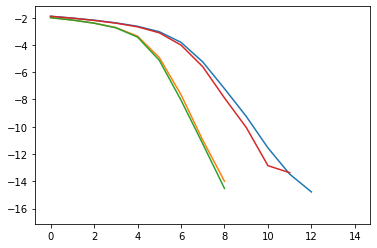

In [11]:
plt.plot(np.log(answear[0][1]))